In [1]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch.nn.functional as F
import wfdb
import re
from os.path import exists


import torch
import torch.backends.cudnn as cudnn
# from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import timm

# assert timm.__version__ == "0.3.2"  # version check
import timm.optim.optim_factory as optim_factory

import utils.misc as misc
from utils.misc import NativeScalerWithGradNormCount as NativeScaler

import models_mae

from engine_pretrain import train_one_epoch

/Users/parthagrawal02/Desktop/Carelog/Pretraining/dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import glob
import wfdb
from wfdb import processing
import re
import numpy as np
import torch
dataset = []
files = 0
for n in range(43,44):
    for j in range(0, 10):
        for filepath in glob.iglob( '/Users/parthagrawal02/Desktop/Carelog/ECG_CNN' + '/physionet/WFDBRecords/' + f"{n:02}" +  '/' + f"{n:02}" + str(j) +  '/*.hea'):
            try:
                ecg_record = wfdb.rdsamp(filepath[:-4])
            except Exception:
                continue
            # annots = wfdb.Annotation(filepath[:-4], 'hea')
            # print(ecg_record[0].transpose(1,0).shape)
            numbers = re.findall(r'\d+', ecg_record[1]['comments'][2])
            output_array = list(map(int, numbers))
            lx = []
            for chan in range(ecg_record[0].shape[1]):
                resampled_x, _ = wfdb.processing.resample_sig(ecg_record[0][:, chan], 500, 100)
                lx.append(resampled_x)
            lx = torch.from_numpy(np.array(lx))
            mean = lx.mean(dim=-1, keepdim=True)
            var = lx.var(dim=-1, keepdim=True)
            lx = (lx - mean) / (var + 1.e-6)**.5

            dataset.append(lx)

dataset = np.array(dataset)
dataset = dataset.astype(np.double, copy=False)
X = torch.from_numpy(dataset[:, :, :])
X = X[:, None, :, :]

In [69]:
# Reconstruction from the 220th epoch checkpoints
from models_mae import mae_vit_1dcnn
test_model = mae_vit_1dcnn()
test_model = test_model.double()
test_model.eval()
# Load model checkpoints
checkpoint_loc = 'checkpoint-180.pth'
checkpoint = torch.load(checkpoint_loc, map_location='cpu')
test_model.load_state_dict(checkpoint['model'], strict = True)

<All keys matched successfully>

In [70]:
def unpatchify(x):
    """
    x: (N, L, patch_size_height*patch_size_width*1)
    imgs: (N, 1, H, W) - 12 channel ECG - H = No. of channels, W = Length of ECG signal (1000 in this case)
    """
    ph = 1
    pw = 50

    # h = w = int(x.shape[1]**.5)
    # assert h * w == x.shape[1]
    h = 12
    w = x.shape[1]//12

    x = x.reshape(shape=(h, w, ph, pw, 1))
    x = torch.einsum('hwpqc->chpwq', x)
    imgs = x.reshape(shape=(1, h * ph, w * pw))
    return imgs


In [71]:
i = 500
input = X[i:i+1]
loss, pred, mask  = test_model(X[i:i+1])
loss

tensor(0.1910, dtype=torch.float64, grad_fn=<DivBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

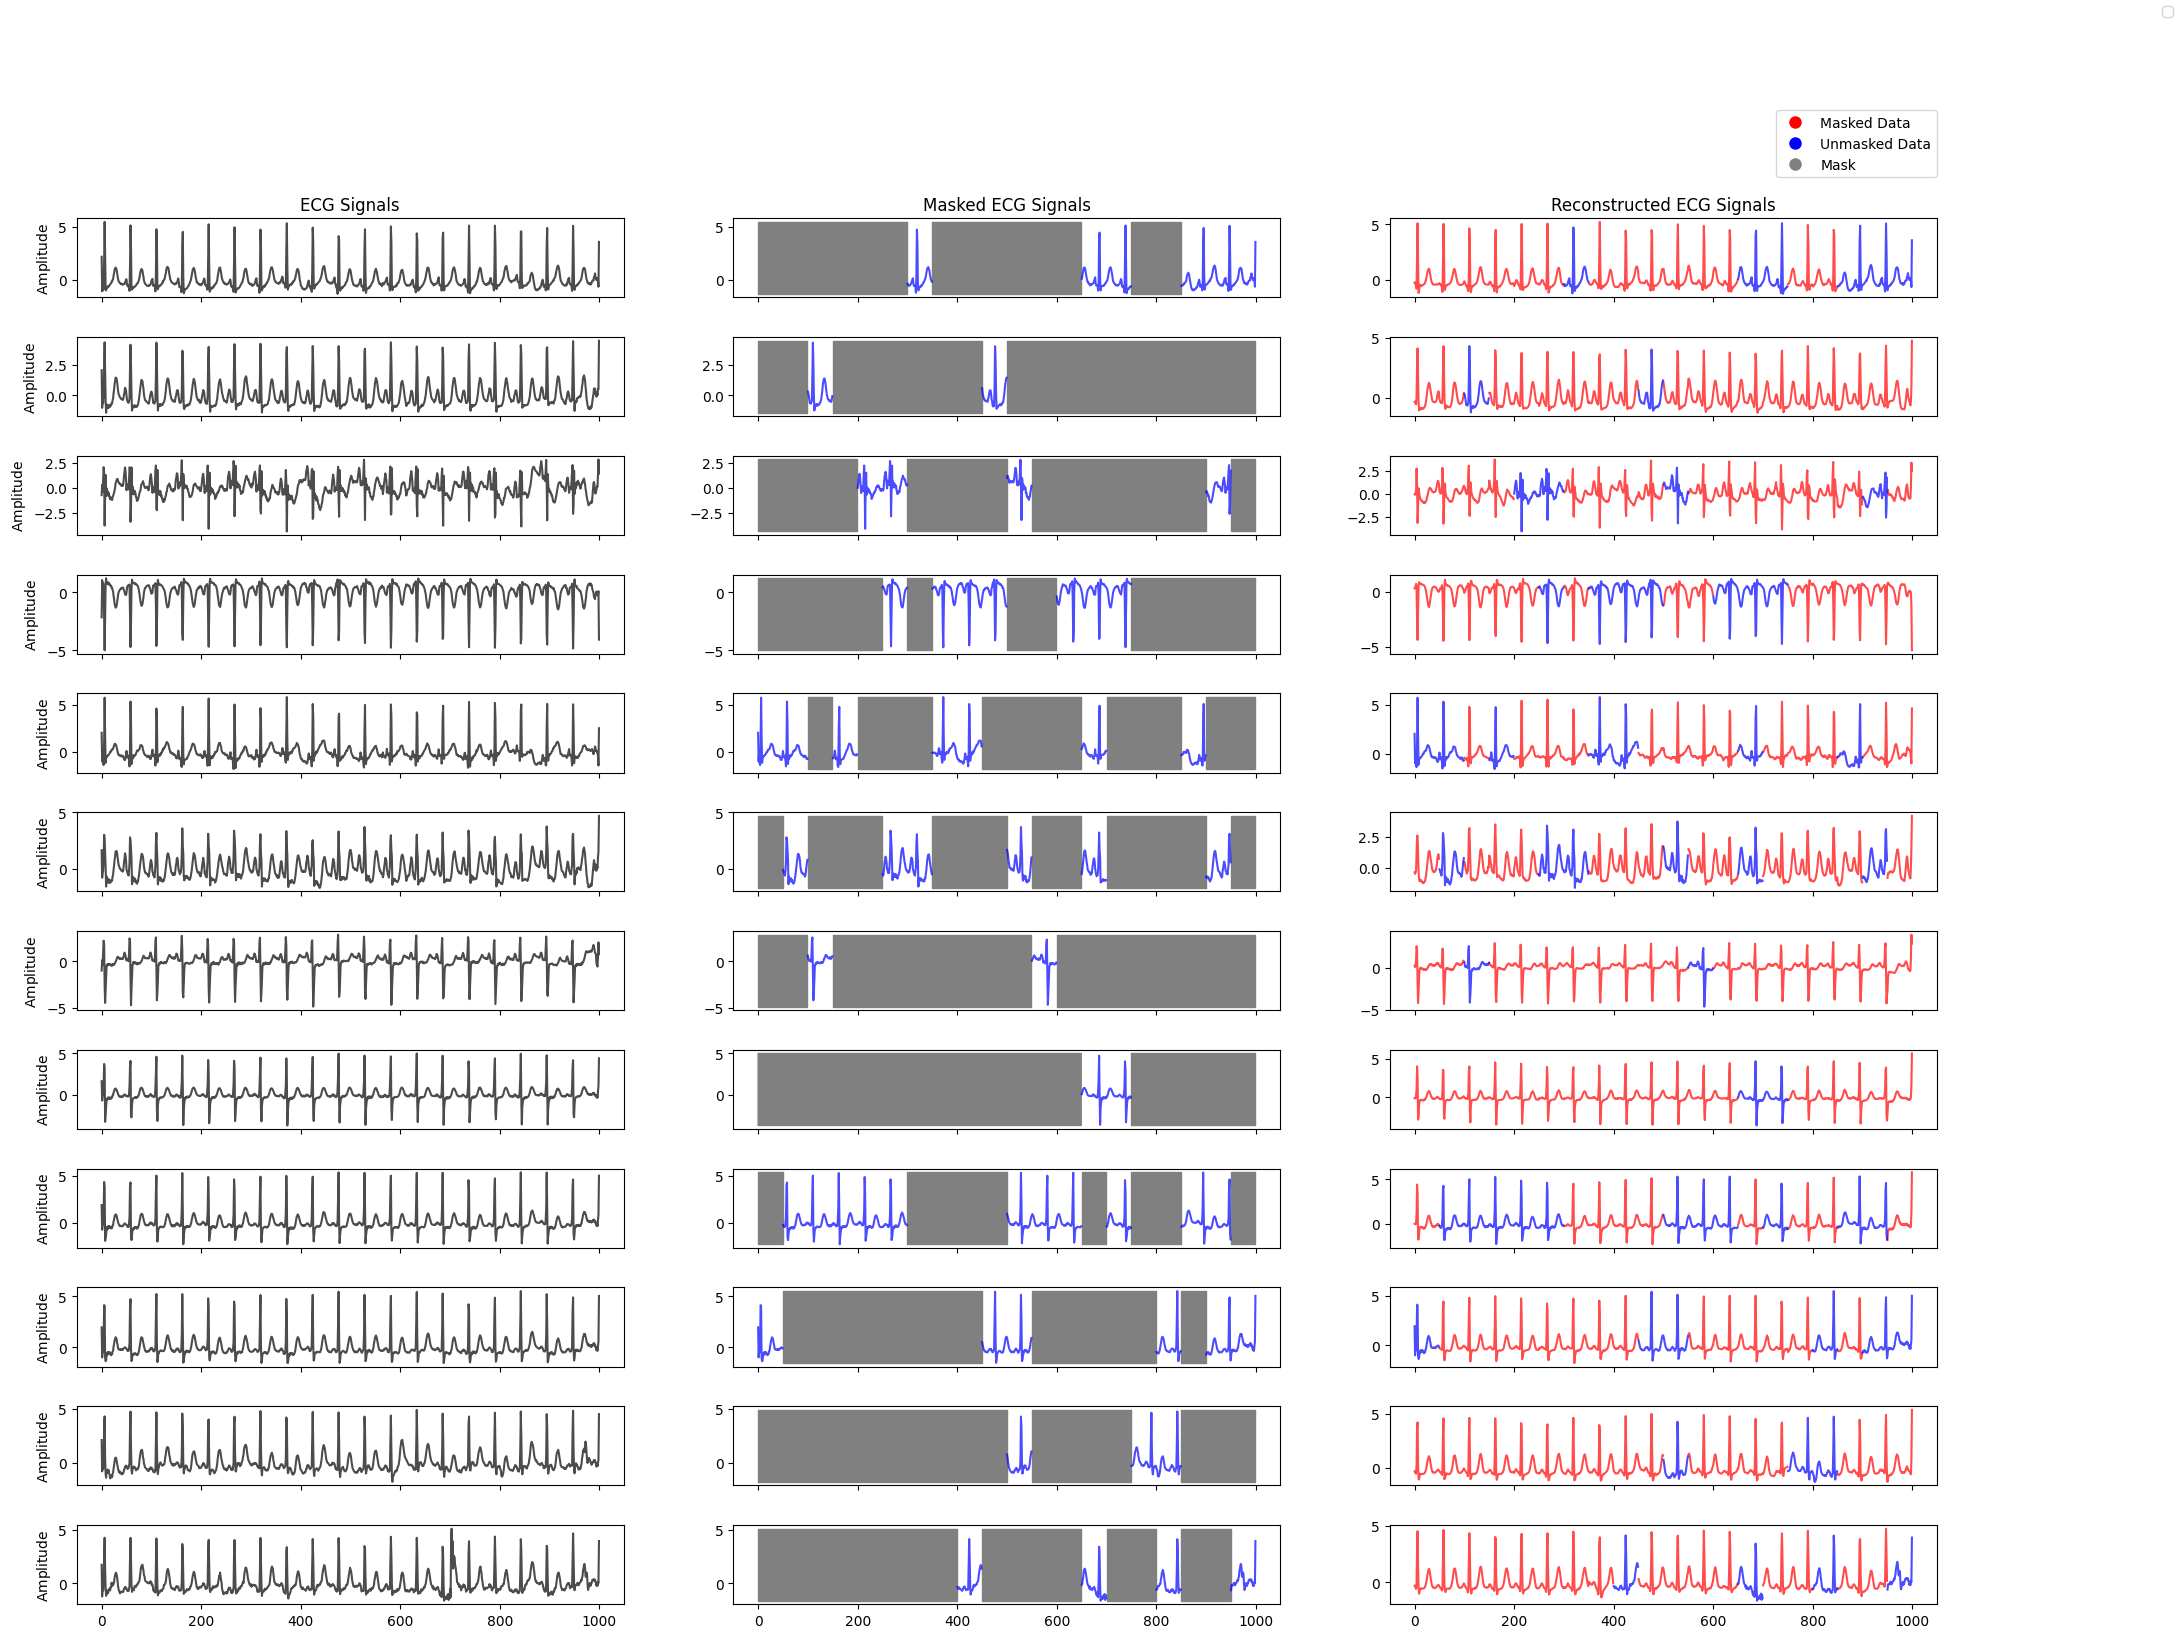

In [86]:
import matplotlib.pyplot as plt
import numpy as np

ecg_data = unpatchify(pred).detach().numpy()
mask_data = np.repeat(mask[0], 50).reshape((12, 1000))

time_axis = np.arange(0, 1000)

# Create subplots for the two sets of ECG signals side by side
fig, axes = plt.subplots(12, 3, figsize=(24, 18), sharex=True, gridspec_kw={'wspace': 0.2, 'hspace': 0.5})

# Set common labels for the y-axes
for i in range(12):
    axes[i, 0].set_ylabel(r'$\mathrm{Amplitude}$')

# Define colors for masked and unmasked data
masked_color = 'red'
unmasked_color = 'blue'
mask_fill_color = 'gray'  # Color for masked areas


# Plot each channel for the first set of ECG signals (INPUT and RECONSTRUCTION)
for i in range(12):
    input_channel = input[0, 0, i, :]
    ecg_channel = ecg_data[0, i, :]
    mask_channel = mask_data[i, :]

    unmasked_data_input = np.where(mask_channel == 0, input_channel, np.nan)
    masked_data_input = np.where(mask_channel == 1, input_channel, np.nan)

    unmasked_data_ecg = np.where(mask_channel == 0, ecg_channel, np.nan)
    masked_data_ecg = np.where(mask_channel == 1, ecg_channel, np.nan)

    # axes[i, 0].plot(time_axis, masked_data_input, color=masked_color, alpha=0.7)
    # axes[i, 0].plot(time_axis, unmasked_data_input, color=unmasked_color, alpha=0.7)
    # axes[i, 1].plot(time_axis, masked_data_ecg, color='black', alpha=0.7)
    # axes[i, 1].plot(time_axis, unmasked_data_input, color='black', alpha=0.7)
    axes[i, 0].plot(time_axis, input_channel, color='black', alpha=0.7)

    axes[i, 1].fill_between(time_axis, np.nanmin(input_channel), np.nanmax(input_channel), where=mask_channel == 1,
                            color=mask_fill_color, alpha=1)
    axes[i, 1].plot(time_axis, masked_data_input, color=masked_color, alpha=0)
    axes[i, 1].plot(time_axis, unmasked_data_input, color=unmasked_color, alpha=0.7)

    # axes[i, 1].fill_between(time_axis, np.nanmin(ecg_channel), np.nanmax(ecg_channel), where=mask_channel == 1,
    #                         color=mask_fill_color, alpha=0.9)
    axes[i, 2].plot(time_axis, masked_data_ecg, color=masked_color, alpha=0.7)
    axes[i, 2].plot(time_axis, unmasked_data_input, color=unmasked_color, alpha=0.7)

# Set labels for the entire column (Input and Reconstruction)
axes[0, 0].set_title('ECG Signals')
axes[0, 1].set_title('Masked ECG Signals')
axes[0, 2].set_title('Reconstructed ECG Signals')

# Create a legend outside the subplots
legend_labels = ['Masked Data', 'Unmasked Data', 'Mask']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=masked_color, markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=unmasked_color, markersize=10), 
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=mask_fill_color, markersize=10)
                  ]
fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(0.9, 0.94), borderaxespad=0.)
fig.legend()
# Adjust the layout
# plt.tight_layout()

# Remove legends for individual subplots
for i in range(12):
    axes[i, 0].legend().set_visible(False)
    axes[i, 1].legend().set_visible(False)

plt.show()

In [1]:
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import re
import wfdb
from wfdb import processing
import pdb
class CustomDataset(Dataset):
    def __init__(self, data_path: str = "", start: int = 0, end: int = 46):
        self.class_map  = {
        426177001: 1,
        426783006: 2,
        164889003: 3,
        427084000: 4,
        164890007: 5,
        427393009: 6,
        426761007: 7,
        713422000: 8,
        233896004: 9,
        233897008: 0
        }
        self.data_path = data_path
        self.data = []
        y = []
        for n in range(start, end):
            for j in range(0, 10):
                for filepath in glob.iglob(self.data_path + '/WFDBRecords/' + f"{n:02}" +  '/' + f"{n:02}" + str(j) +  '/*.hea'):
                    try:
                        ecg_record = wfdb.rdsamp(filepath[:-4])
                    except Exception:
                        continue
                    # pdb.set_trace()
                    if(np.isnan(ecg_record[0]).any()):
                        print(str(filepath))
                        continue
                    numbers = re.findall(r'\d+', ecg_record[1]['comments'][2])
                    output_array = list(map(int, numbers))
                    for j in output_array: # Only classify into one of the predecided classes.
                        if int(j) in self.class_map:
                            output_array = j
                    if isinstance(output_array, list):
                        continue
                    y.append(output_array)
                    self.data.append([filepath, output_array])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ecg_path, class_name = self.data[idx]
        ecg_record = wfdb.rdsamp(ecg_path[:-4])
        lx = []
        for chan in range(ecg_record[0].shape[1]):
            resampled_x, _ = wfdb.processing.resample_sig(ecg_record[0][:, chan], 500, 100)
            lx.append(resampled_x)

        class_id = self.class_map[class_name]
        ecg_tensor = torch.from_numpy(np.array(lx))
        img_tensor = ecg_tensor[None, :, :]
        # mean = img_tensor.mean(dim=-1, keepdim=True)
        # var = img_tensor.var(dim=-1, keepdim=True)
        # img_tensor = (img_tensor - mean) / (var + 1.e-6)**.5
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [2]:
data = CustomDataset('/Users/parthagrawal02/Desktop/Carelog/ECG_CNN/physionet', 0, 3)

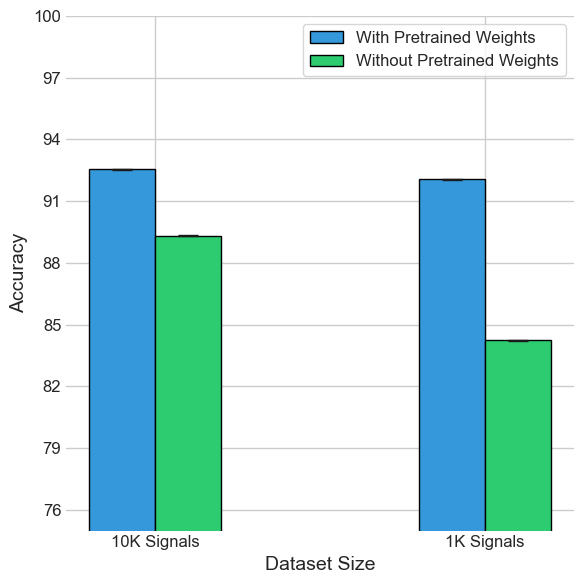

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sns.set(style="whitegrid")

# Define the names of the models and training methods
models = ['10K Signals', '1K Signals']
training_methods = ['With Pretrained Weights', 'Without Pretrained Weights']

# Accuracies for each model and training method
accuracies = {
    '10K Signals': [92.56, 89.32],
    '35K Signals': [96.2, 95.3],
    '1K Signals': [92.06, 84.24]
}

bar_width = 0.2

# Create an array of indices for the x-axis positions
indices = np.arange(len(models))

# Create a figure and axis with better sizing
fig, ax = plt.subplots(figsize=(6, 6))

# Define a tech-inspired color palette for the bars
colors = ['#3498db', '#2ecc71']

# Plot the bars for each model and training method
for i, method in enumerate(training_methods):
    accuracies_method = [accuracies[model][i] for model in models]
    bar_positions = indices + i * bar_width
    error_bars = [0.02, 0.02]  # Example error bars (adjust as needed)
    
    ax.bar(
        bar_positions, 
        accuracies_method, 
        bar_width, 
        label=method, 
        color=colors[i], 
        edgecolor='black',
        yerr=error_bars,  # Add error bars
        capsize=7,        # Size of error bar caps
    )

# Set labels and title
ax.set_xlabel('Dataset Size', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
# ax.set_title('Accuracy Comparison', fontsize=16)
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

# Adjust the plot layout
ax.set_ylim(75, 100)  # Set the y-axis limits
ax.set_yticks(np.arange(76, 101, 3))
plt.tick_params(axis='both', which='both', direction='in', labelsize=12)

# Show the plot with Seaborn aesthetics
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
